In [393]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import statsmodels.formula.api as smf

In [394]:
dfr=pd.read_csv('tempSiteRatings.csv')
dfd=pd.read_csv('tempUrlMetrics.csv')
dfd['rating']=dfr['rating']
dfd.to_csv('dataReg.csv')

In [395]:
data=pd.read_csv('dataReg.csv')
data.drop(['Unnamed: 0'],1, inplace=True)

In [396]:
def changeColName(data):
    try:
        columns=['word_count','body_text_percent','emphasized_text_percent','text_position_changes','text_cluster_count','link_count','page_size','graphic_percent','graphic_count','colour_count','font_count','colourfulness','visual_complexity','rating']
        data.columns=columns
    except:
        columns=['word_count','body_text_percent','emphasized_text_percent','text_position_changes','text_cluster_count','link_count','page_size','graphic_percent','graphic_count','colour_count','font_count','colourfulness','visual_complexity']
        data.columns=columns
    return data
def dropMetrics(data):
    try:
        data.drop(['id','url'],1, inplace=True)#,'p1','p2','p4','p6','p7','p10','p11','p12','p13'
    except:
        data.drop(['slno','url'],1, inplace=True)
    return data
def stdNormal(data,mean,std):
    x = data.values #returns a numpy array
    columns=data.columns
    x_scaled=(x-mean)/std
    data=pd.DataFrame(x_scaled,columns=columns)
    return data
def catCol(data,col):
    data[col+'_high']=np.zeros(data[col].shape)
    data[col+'_avg']=np.ones(data[col].shape)
    data[col+'_low']=np.zeros(data[col].shape)

    data[col+'_high'][np.where(data[col]>.431)[0]]=1.0
    data[col+'_avg'][np.where(data[col]>.431)[0]]=0.0
    data[col+'_avg'][np.where(data[col]<-.431)[0]]=0.0
    data[col+'_low'][np.where(data[col]<-.431)[0]]=1.0
    data.drop([col],1,inplace=True)
    return data
def catColPdf(data,col):
    import scipy.stats
    
    mean_high=np.mean(data[col][np.where(data[col]>.431)[0]])
    std_high=np.std(data[col][np.where(data[col]>.431)[0]])


    mean_avg=np.mean(data[col][np.where(abs(data[col])<.431)[0]])
    std_avg=np.std(data[col][np.where(abs(data[col])<.431)[0]])

    mean_low=np.mean(data[col][np.where(data[col]<-.431)[0]])
    std_low=np.std(data[col][np.where(data[col]<-.431)[0]])

    data[col+'_high']=scipy.stats.norm(mean_high,std_high).pdf(data[col].values)
    data[col+'_avg']=scipy.stats.norm(mean_avg,std_avg).pdf(data[col].values)
    data[col+'_low']=scipy.stats.norm(mean_low,std_low).pdf(data[col].values)
    
    data.drop([col],1,inplace=True)
    
    return data
def preProcess(data,mean,std):
    data=changeColName(data)
    try:
        rating=data['rating']
        data.drop(['rating'],1,inplace=True)
    except:
        pass
    data=stdNormal(data,mean,std)
    data=catCol(data,'word_count')
    data=catCol(data,'page_size') 
    data=catCol(data,'colourfulness') 
    data=catCol(data,'visual_complexity') 
    try:
        data['rating']=rating
    except:
        pass
    return data

In [397]:
data=dropMetrics(data)

In [398]:
mean=np.mean(data.values[:,:-1],axis=0)
std=np.std(data.values[:,:-1],axis=0)


In [399]:
data=preProcess(data,mean,std)
irrCol=['emphasized_text_percent','font_count']
data.drop(irrCol,1,inplace=True)

/home/abhiavk/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in divide


In [400]:
correlation = data.corr(method='pearson')
columns = correlation.nlargest(30,'rating').index
columns

Index([u'rating', u'word_count_avg', u'colourfulness_low', u'graphic_count',
       u'page_size_high', u'page_size_avg', u'body_text_percent',
       u'graphic_percent', u'visual_complexity_low', u'visual_complexity_high',
       u'visual_complexity_avg', u'colour_count', u'link_count',
       u'text_position_changes', u'colourfulness_high', u'colourfulness_avg',
       u'word_count_low', u'word_count_high', u'text_cluster_count',
       u'page_size_low'],
      dtype='object')

In [401]:
def corr():
    fig, ax = plt.subplots(figsize=(30,30))    
    correlation_map = np.corrcoef(data[columns].values.T)
    sns.set(font_scale=2.4)
    heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, annot_kws={"size": 30},square=True, fmt='.2f',yticklabels=columns.values, xticklabels=columns.values)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 50
    plt.savefig('corr')

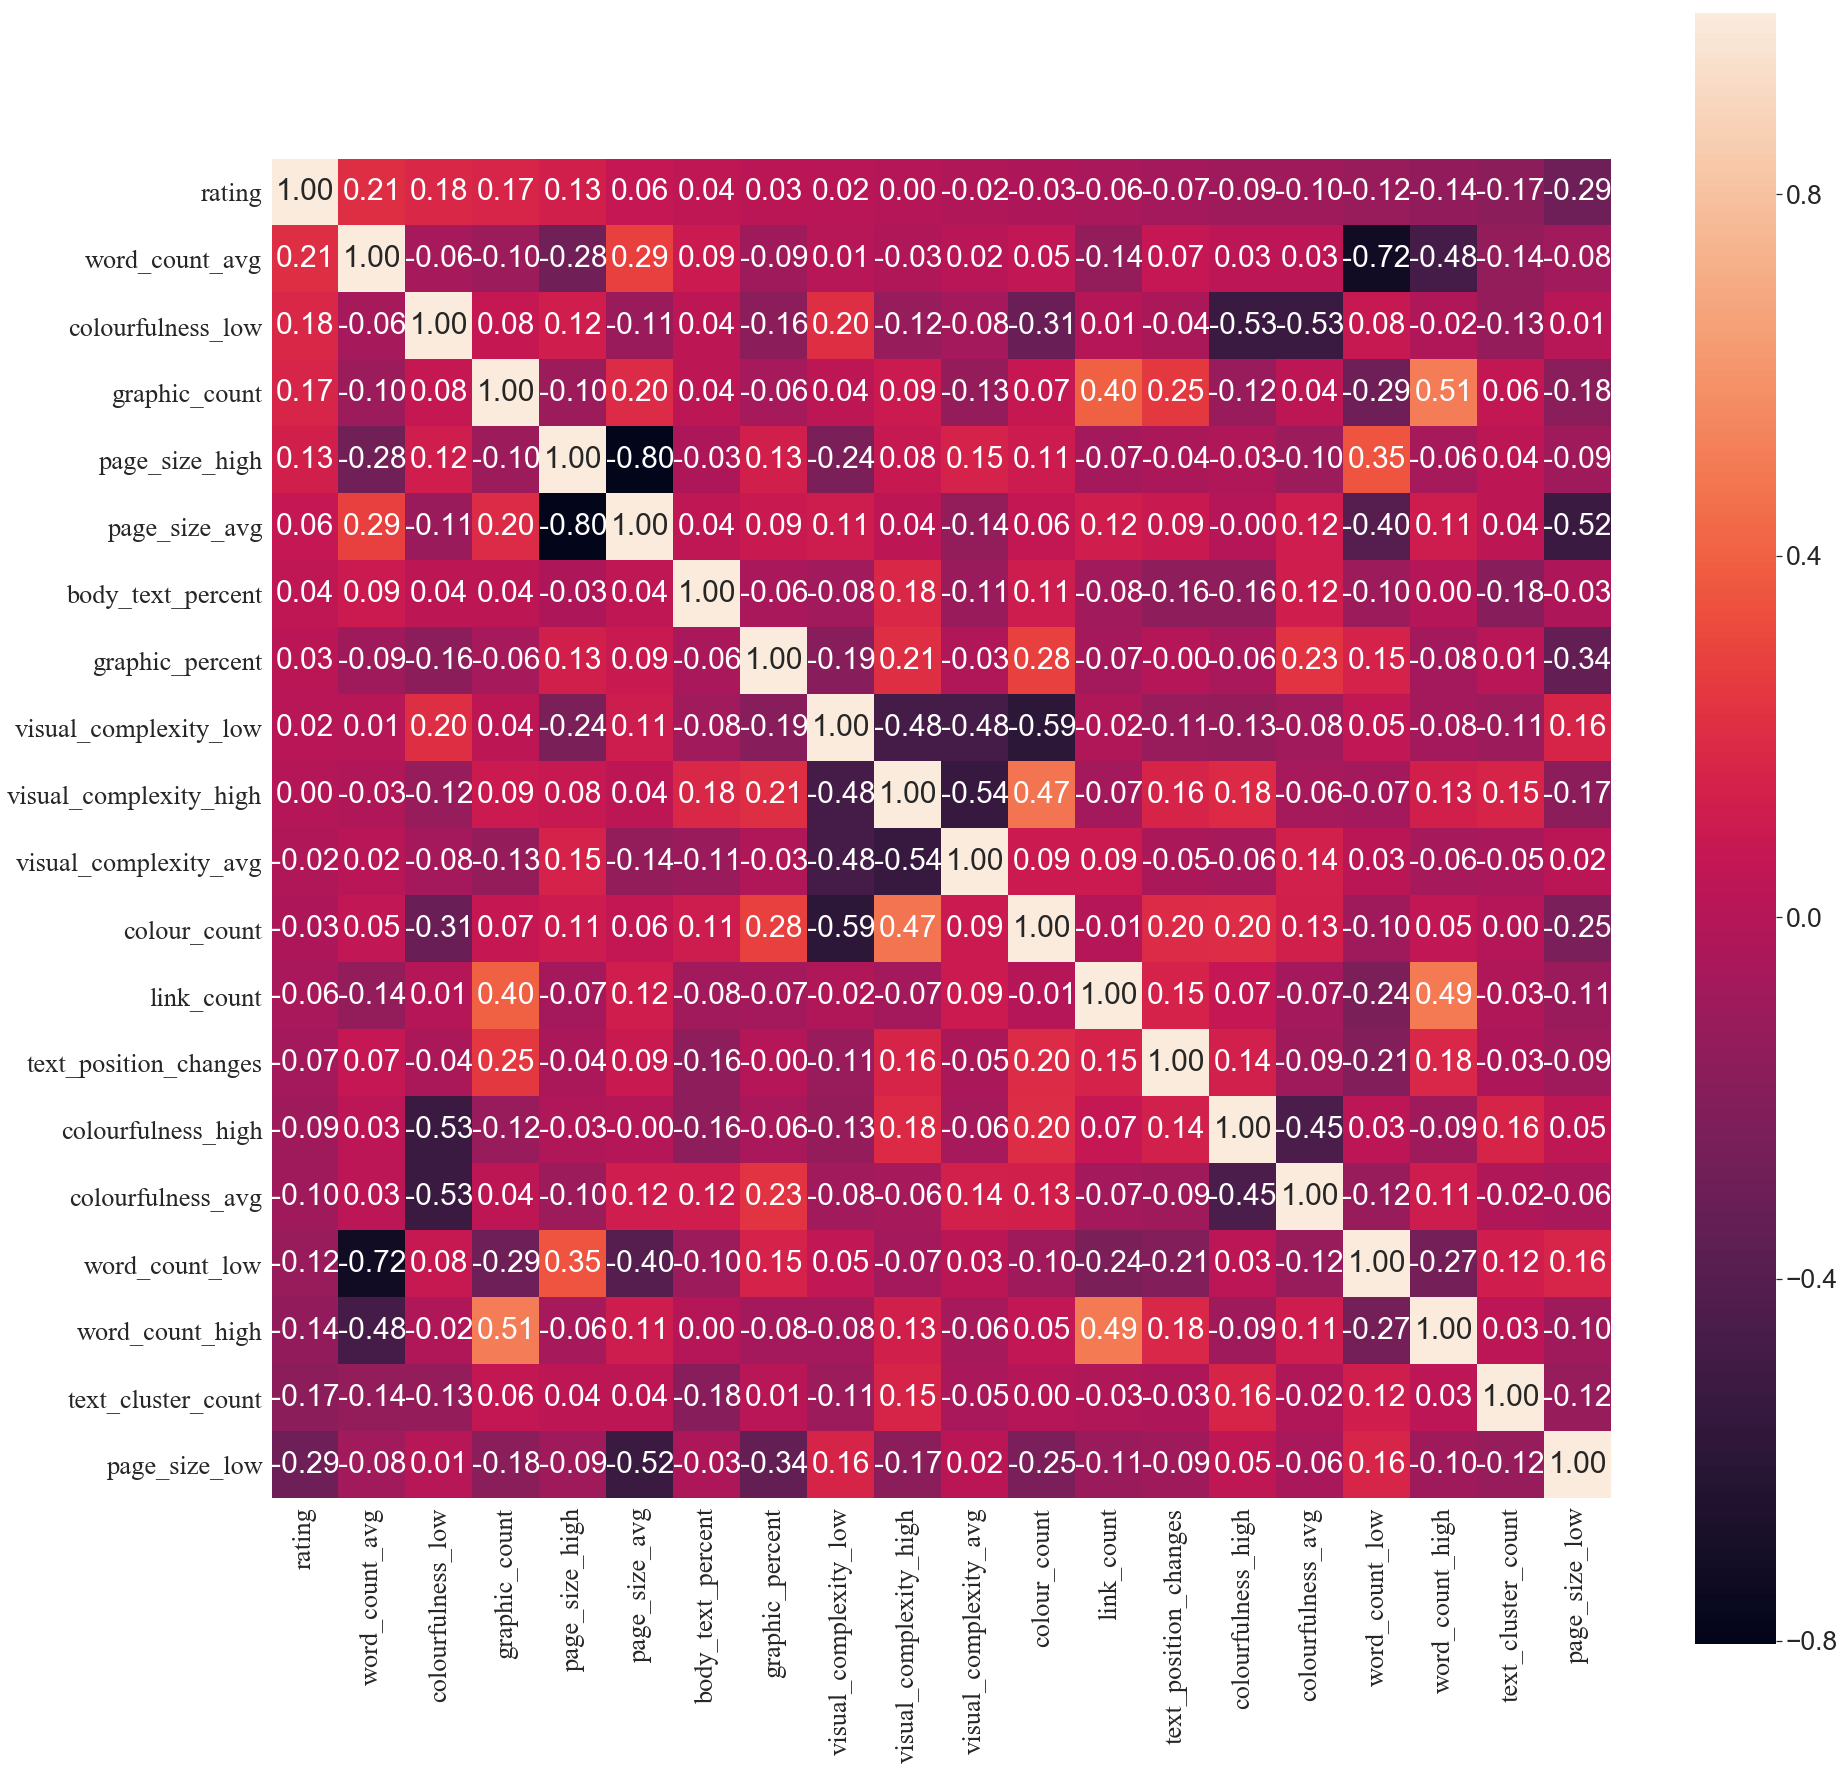

In [402]:
corr()

In [403]:
columns=columns.tolist()
columns.sort()
columns=pd.Index(columns)
columns=columns.drop('rating')

In [404]:
Y=data['rating'].values
X=data[columns].values

In [411]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True,test_size=0.3, random_state=1)

def LinearReg():
    from sklearn.linear_model import LinearRegression
    reg =LinearRegression()
    return reg
def RidgeReg():
    from sklearn.linear_model import Ridge
    reg =Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,normalize=False, random_state=1, solver='svd', tol=0.001)
    return reg
def MLPReg():
    from sklearn.neural_network import MLPRegressor
    reg=MLPRegressor(hidden_layer_sizes=(7,),activation='logistic',solver='adam', max_iter=10000,batch_size=10,alpha=0.01)
    return reg
def KNNReg():
    from sklearn.neighbors import KNeighborsRegressor
    reg=KNeighborsRegressor(n_neighbors=5,algorithm='brute',metric='manhattan')
    return reg
def RMS_test(reg):
    from sklearn.metrics import mean_squared_error
    Y_pred=reg.predict(X_test)
    return Y_pred,mean_squared_error(Y_test, Y_pred)
def RMS_train(reg):
    from sklearn.metrics import mean_squared_error
    Y_pred=reg.predict(X_train)
    return Y_pred,mean_squared_error(Y_train, Y_pred)
def RMS(reg):
    from sklearn.metrics import mean_squared_error
    Y_pred=reg.predict(X)
    return Y_pred,mean_squared_error(Y, Y_pred)
def getRMS(reg):
    print(RMS_test(reg)[1],RMS_train(reg)[1])

def getRV(reg):
    Y_pred=reg.predict(X_test)
    rsq=np.sum((Y_pred-np.mean(Y_pred))**2)/np.sum((Y_test-np.mean(Y_test))**2)
    N,p=X_test.shape
    adjRsq=1-((1-rsq)*(N-1)/(N-p-1))
    print(rsq,adjRsq)
def getURV(reg):
    Y_pred=reg.predict(X)
    rsq=np.sum((Y_pred-np.mean(Y_pred))**2)/np.sum((Y-np.mean(Y))**2)
    N,p=X.shape
    adjRsq=1-((1-rsq)*(N-1)/(N-p-1))
    print(rsq,adjRsq)

In [412]:
regLinear=LinearReg()
regLinear.fit(X_train,Y_train)

regRidge=RidgeReg()
regRidge.fit(X_train,Y_train)

regMLP=MLPReg()
regMLP.fit(X_train,Y_train)

regKNN=KNNReg()
regKNN.fit(X_train,Y_train)

temp=0

In [413]:
regLinear.intercept_,regLinear.coef_,columns

(4.079409161998166,
 array([-0.06122946,  0.05310072, -0.16901776,  0.08623467,  0.08278309,
         0.25844812, -0.12353413, -0.08870703,  0.24535606,  0.83338738,
        -1.07874344, -0.16206067, -0.1361118 , -0.18610132,  0.15487317,
         0.03122816,  0.37032936, -0.25493173, -0.11539763]),
 Index([u'body_text_percent', u'colour_count', u'colourfulness_avg',
        u'colourfulness_high', u'colourfulness_low', u'graphic_count',
        u'graphic_percent', u'link_count', u'page_size_avg', u'page_size_high',
        u'page_size_low', u'text_cluster_count', u'text_position_changes',
        u'visual_complexity_avg', u'visual_complexity_high',
        u'visual_complexity_low', u'word_count_avg', u'word_count_high',
        u'word_count_low'],
       dtype='object'))

In [414]:
getRMS(regLinear)
getRMS(regRidge)
getRMS(regMLP)
getRMS(regKNN)

(0.8244547791465311, 0.4550063551423563)
(0.7921293832493556, 0.4602724245133802)
(0.6929605268728626, 0.1553978257545053)
(0.8474273231200308, 0.48182256787147865)


In [415]:
getRV(regLinear)
getRV(regRidge)
getRV(regMLP)
getRV(regKNN)


(0.37176266307287875, -0.9545161593288216)
(0.29383215647886446, -1.1969666242879775)
(0.48815711211331086, -0.5924000956474775)
(0.15329728705929768, -1.6341862180377404)


In [416]:
getURV(regLinear)
getURV(regRidge)
getURV(regMLP)
getURV(regKNN)

(0.3926753208134159, 0.23674060588713086)
(0.3193192136739357, 0.14454982259021643)
(0.5498553942496326, 0.43427772520561936)
(0.1442937546246311, -0.07541460567445002)


In [417]:
regLinear=LinearReg()
regLinear.fit(X,Y)
getRMS(regLinear)

(0.5282990418788358, 0.503905487225769)


In [246]:
Y_total_Pred=regMLP.predict(X)
import scipy.stats as stats
from sklearn import feature_selection
stats.f_oneway(Y_total_Pred,Y)
feature_selection.f_regression(X,Y)


(array([0.18150971, 0.08448609, 0.50293348, 2.68325358, 0.05981737,
        0.28394254, 0.27761701, 2.89436251, 0.50293891, 0.28244099,
        0.39454348]),
 array([0.67107413, 0.77196183, 0.48000736, 0.10482421, 0.80732949,
        0.5954135 , 0.59953555, 0.0922675 , 0.480005  , 0.59638662,
        0.53147696]))

In [247]:
try:
    print(regLinear.coef_)
    print(regLinear.intercept_)
except: 
    pass

[-0.07066504 -0.11053283 -0.03132938  0.58794222  0.01287101  0.34401096
  0.02679205 -0.18876985 -0.10876279  0.13240909 -0.74043314]
4.473231225296443


In [248]:
def rateCountry(reg,regName):
    df={}
    irrCol=['emphasized_text_percent','font_count']
    country=['India','Usa']
    countryIdUrl=[0,0]
    ind=-1
    for year in country:
        ind+=1
        df[str(year)]=pd.read_csv('yearMetrics/tempUrlMetrics'+str(year)+'.csv')
        countryIdUrl[ind]=df[str(year)][['slno','url']]
        df[str(year)]=dropMetrics(df[str(year)])
        df[str(year)]=preProcess(df[str(year)],mean,std)
        df[str(year)].drop(irrCol,1,inplace=True)
    meanYears=np.zeros(2)
    stdYears=np.zeros(2)
    ind=-1
    countryRating=[0,0]
    for year in country:
        ind+=1
        countryRating[ind]=reg.predict(df[str(year)][columns].values)
    x =countryRating[0]
    m=max(x)
    interval=None
    interval=[0,6]
    num_bins = 100
    fig, ax = plt.subplots(figsize=(20,12))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 36
    plt.xlabel("Rating")
    plt.ylabel(" Number of Indian Sites")
    n, bins, patches = plt.hist(x,num_bins, range=interval,facecolor='blue', alpha=0.5)
    plt.savefig("histIndia"+regName)
    plt.show()
    x =countryRating[1]
    m=max(x)
    interval=None
    interval=[0,6]
    num_bins = 100
    fig, ax = plt.subplots(figsize=(20,12))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 36
    plt.xlabel("Rating")
    plt.ylabel(" Number of Usa Sites")
    n, bins, patches = plt.hist(x,num_bins, range=interval,facecolor='blue', alpha=0.5)
    plt.savefig("histUsa"+regName)
    plt.show()

In [254]:
def showEvolution(reg,regName):
    df={}
    irrCol=['emphasized_text_percent','font_count']
    for year in range(2000,2020):
        df[str(year)]=pd.read_csv('yearMetrics/tempMpUrlMetrics'+str(year)+'.csv')
        df[str(year)]=dropMetrics(df[str(year)])
        df[str(year)]=preProcess(df[str(year)],mean,std)
        df[str(year)].drop(irrCol,1,inplace=True)
    meanYears=np.zeros(20)
    stdYears=np.zeros(20)
    for year in range(2000,2020):
        meanYears[year-2000]=np.mean(reg.predict(df[str(year)][columns].values))
        stdYears[year-2000]=np.std(reg.predict(df[str(year)][columns].values))
    fig, ax = plt.subplots(figsize=(6,6))
    x=range(2000,2020)
    y=meanYears
    e=stdYears
    plt.errorbar(x, y, e, fmt='-o')
    plt.xticks(np.arange(min(x), max(x)+1, 5))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    plt.ylabel('Website rating')
    plt.xlabel('Year')
    plt.savefig('modelReg'+regName)

/home/abhiavk/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in divide
/home/abhiavk/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in divide


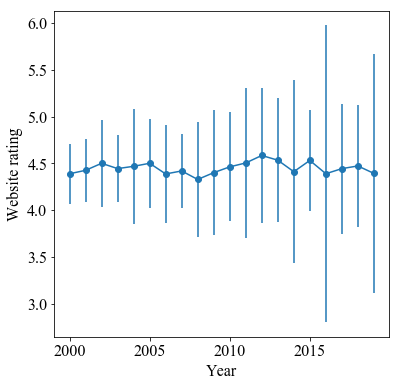

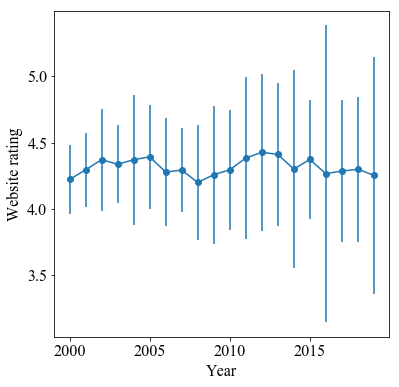

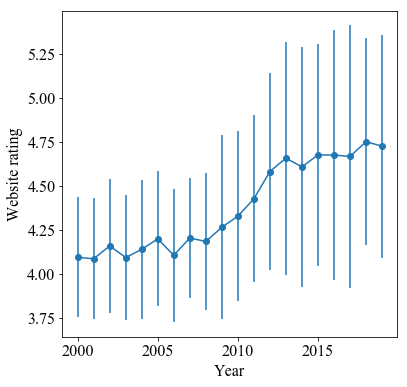

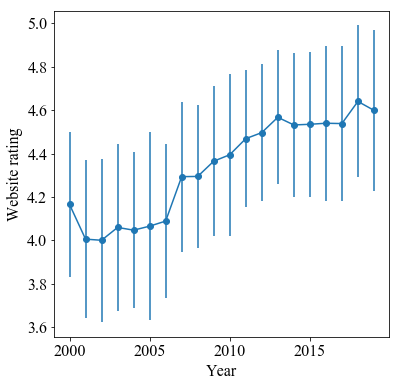

In [255]:
showEvolution(regLinear,"Linear")
showEvolution(regRidge,"Ridge")
showEvolution(regMLP,"MLP")
showEvolution(regKNN,"KNN")

/home/abhiavk/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in divide
/home/abhiavk/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in divide


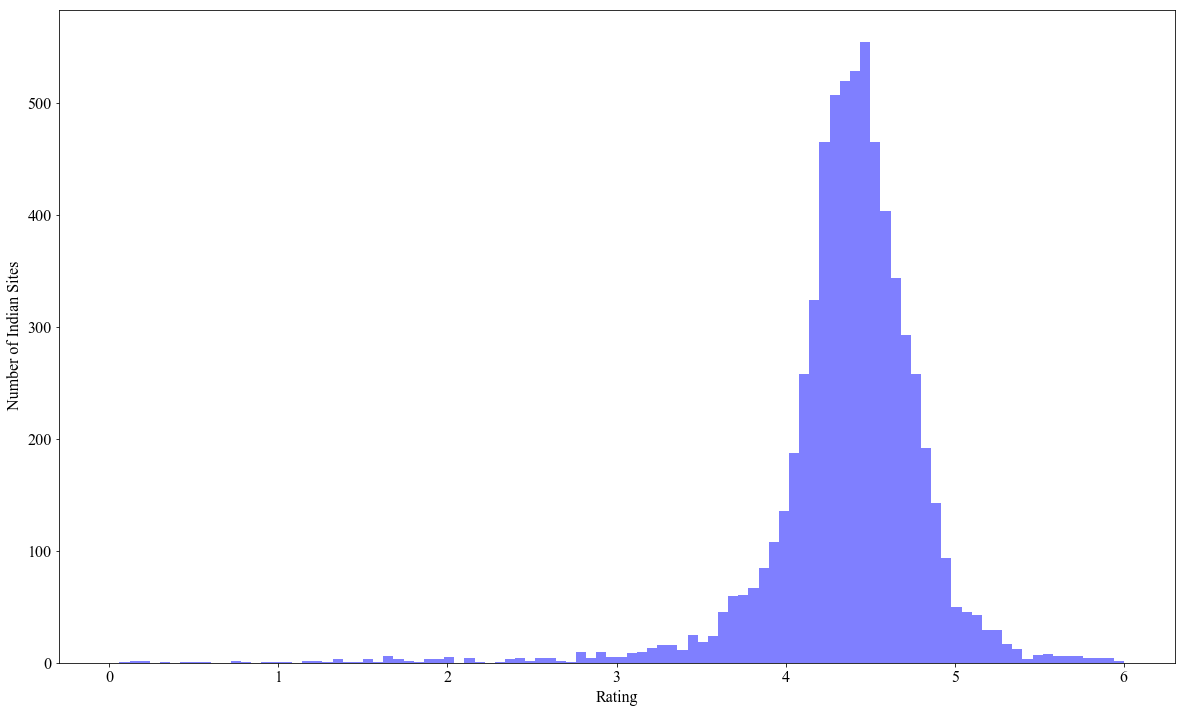

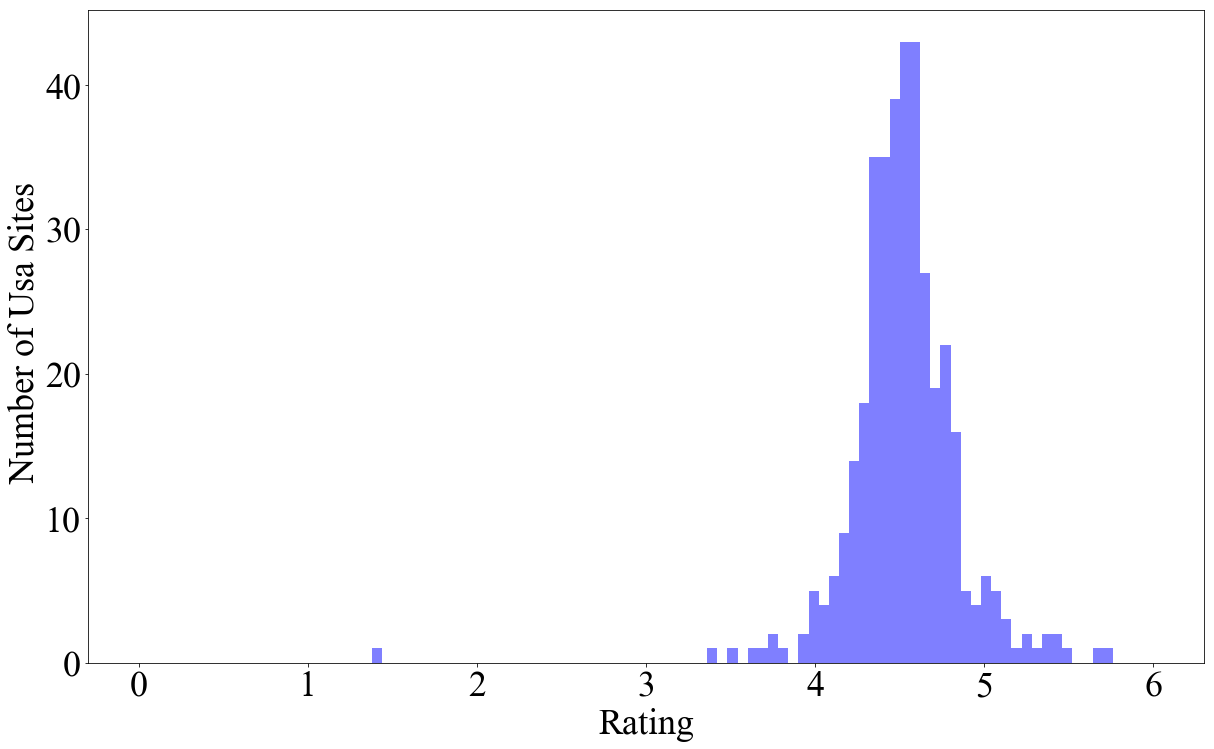

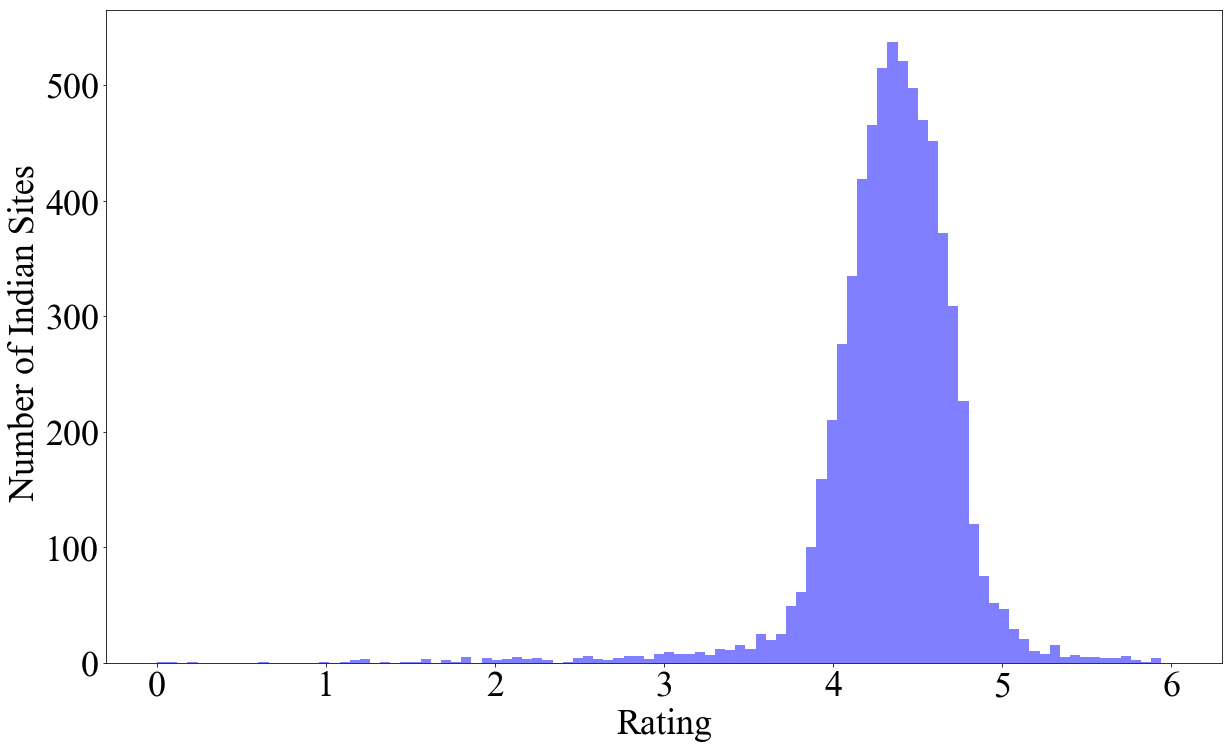

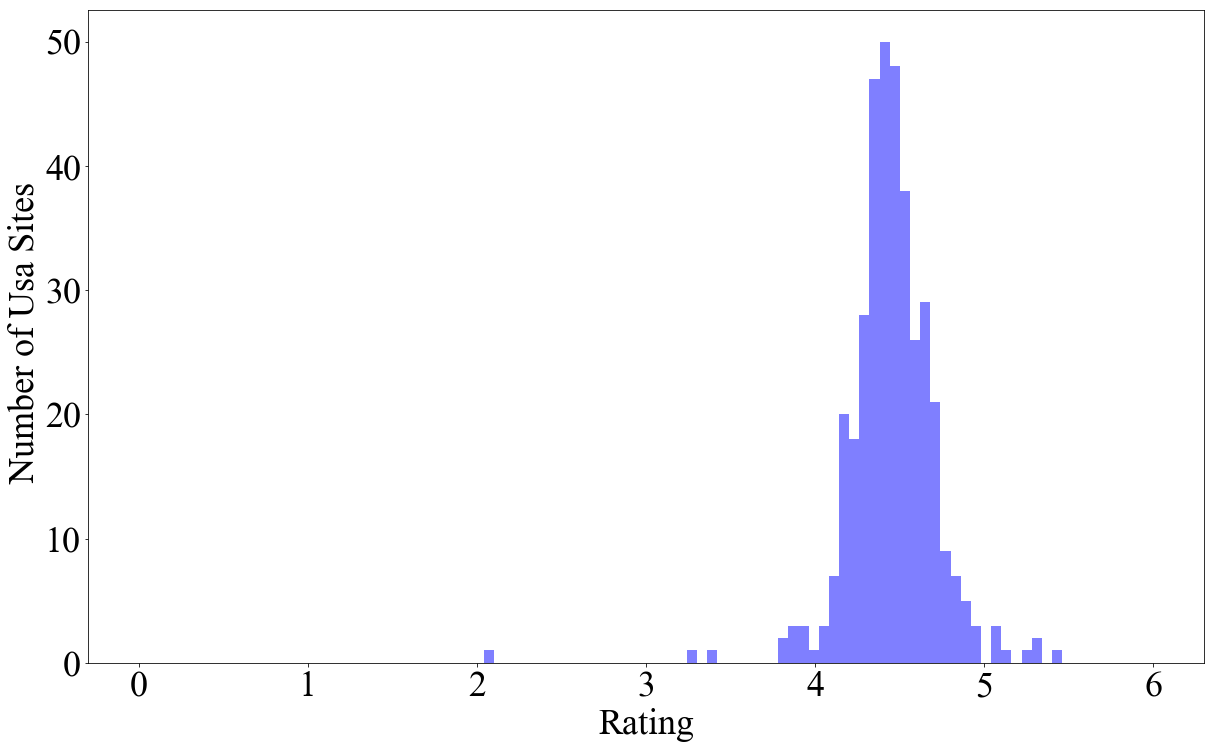

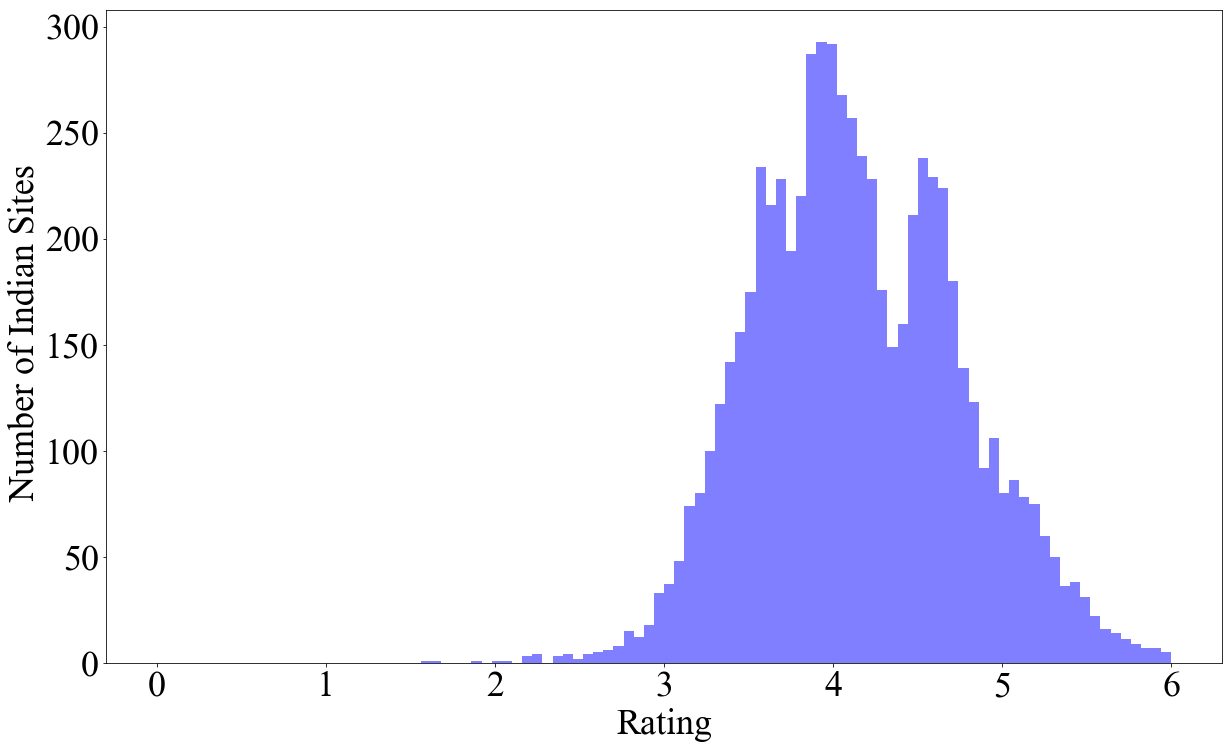

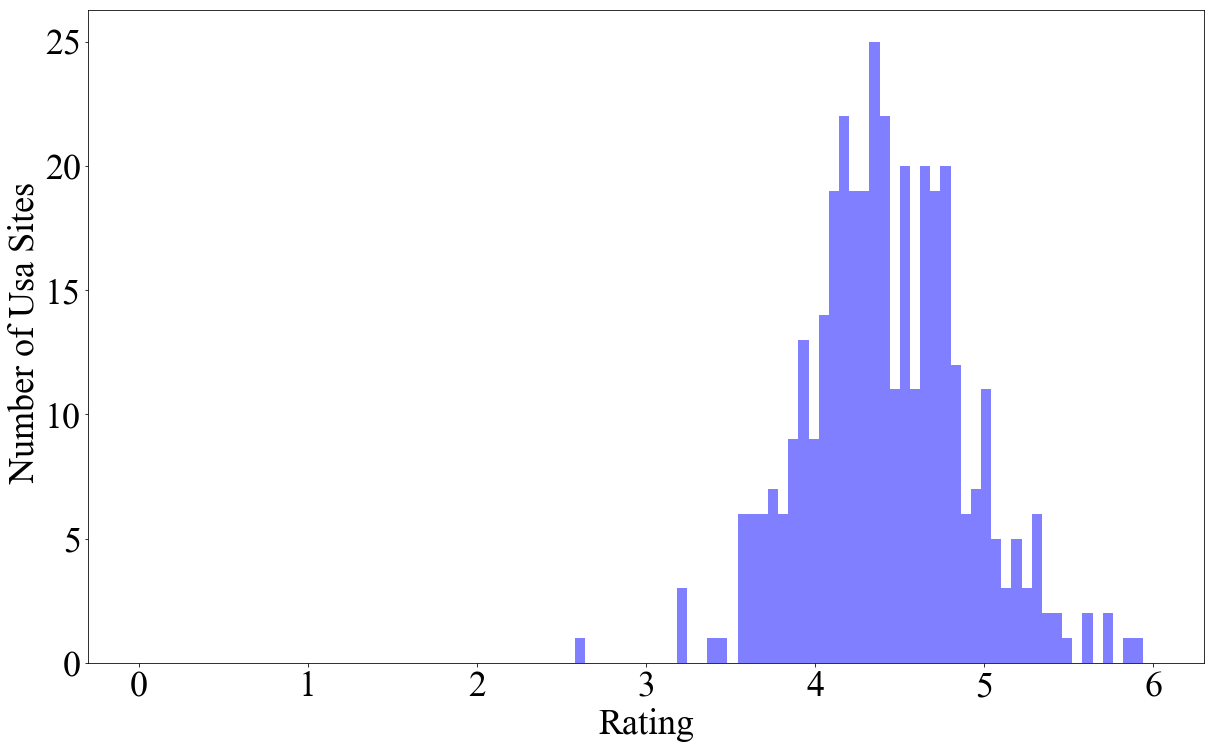

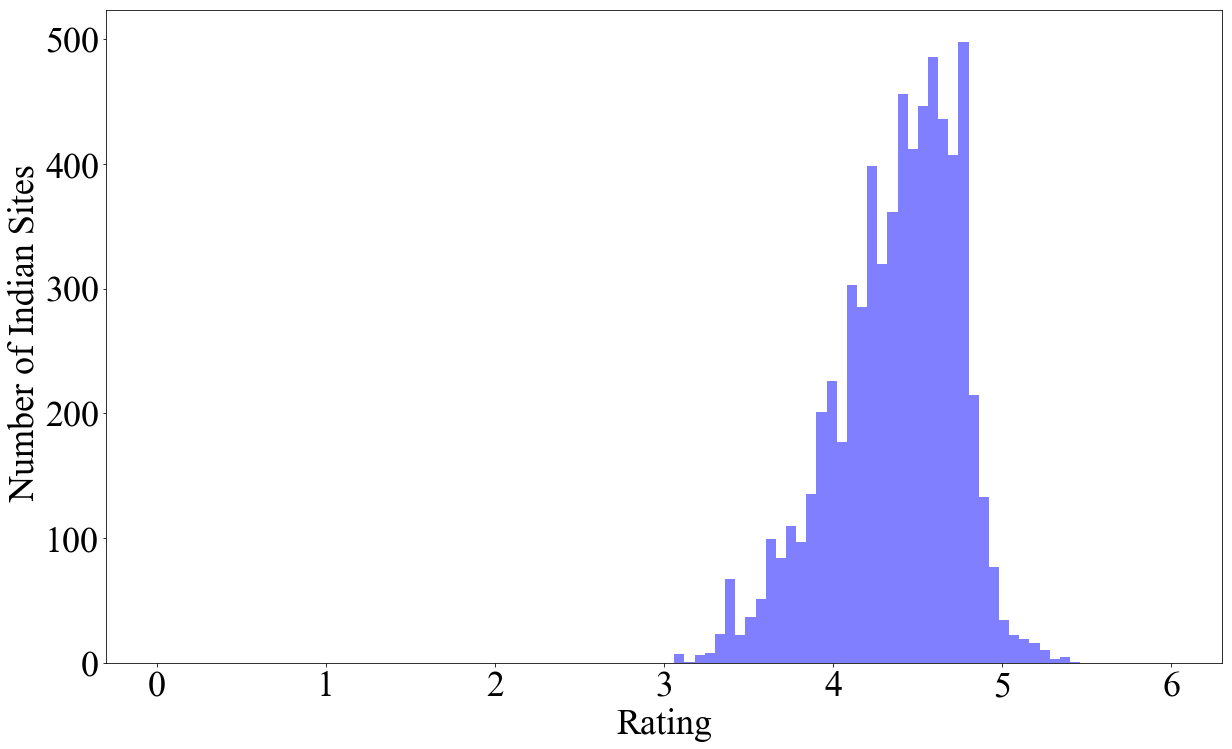

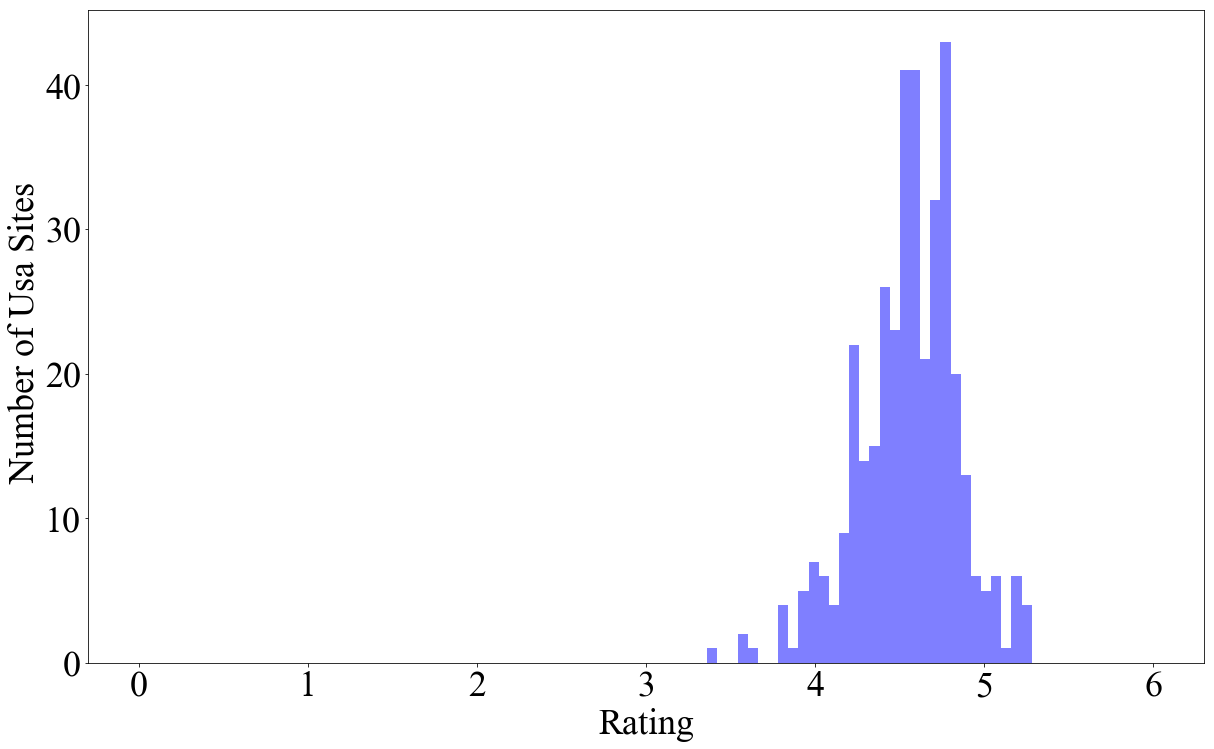

In [256]:
rateCountry(regLinear,"Linear")
rateCountry(regRidge,"Ridge")
rateCountry(regMLP,"MLP")
rateCountry(regKNN,"KNN")

In [175]:
df={}
irrCol=['emphasized_text_percent','font_count']
country=['India','Usa']
countryIdUrl=[0,0]
ind=-1
for year in country:
    ind+=1
    df[str(year)]=pd.read_csv('yearMetrics/tempUrlMetrics'+str(year)+'.csv')
    countryIdUrl[ind]=df[str(year)][['slno','url']]
    df[str(year)]=dropMetrics(df[str(year)])
    df[str(year)]=preProcess(df[str(year)],mean,std)
    df[str(year)].drop(irrCol,1,inplace=True)
meanYears=np.zeros(2)
stdYears=np.zeros(2)
ind=-1
countryRating=[0,0]
for year in country:
    ind+=1
    countryRating[ind]=regLinear.predict(df[str(year)][columns].values)

/home/abhiavk/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in divide
/home/abhiavk/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in divide


In [123]:
countryRating[1].shape

(379,)

In [124]:
countryIdUrl[1].shape

(379, 2)

In [125]:
np.where(countryRating[1]<3)[0]

array([156])

In [126]:
ind=np.where(countryRating[0]>5)[0]
Iind=412

print(countryIdUrl[0].values[ind][Iind])
print(countryRating[0][ind][Iind])

IndexError: index 412 is out of bounds for axis 0 with size 162

In [127]:
ind=np.where(countryRating[0]<3)[0]
Iind=95
print(countryIdUrl[0].values[ind][Iind])
print(countryRating[0][ind][Iind])

[7970 'http://www.pensionersportal.gov.in']
1.3859041169805582


In [128]:
ind=np.where(countryRating[1]>5)[0]
Iind=13
print(countryIdUrl[1].values[ind])
print(countryRating[1][ind])

[[31 'http://www.afrc.af.mil']
 [67 'http://www.cfo.gov']
 [84 'http://www.csb.gov']
 [131 'http://www.fanniemae.com']
 [141 'http://www.federallabs.org']
 [181 'http://www.huduser.org']
 [186 'http://www.imls.gov']
 [271 'http://www.presidio.gov']]
[5.17692998 5.04257408 5.04059684 5.20758944 5.08816646 5.23356131
 5.01652243 5.14452361]


In [129]:
ind=np.where(countryRating[1]<3)[0]
print(countryIdUrl[1].values[ind])
print(countryRating[1][ind])

[[178 'http://www.house.gov']]
[1.69799078]


In [134]:
from statsmodels.stats.weightstats import ttest_ind
ttest_ind(countryRating[1],countryRating[0])

(3.2901532643090183, 0.0010062306905657616, 7071.0)

In [180]:
print(np.mean(countryRating[0]),np.std(countryRating[0]),np.std(countryRating[0])/countryRating[0].shape[0]**0.5)
print(np.mean(countryRating[1]),np.std(countryRating[1]),np.std(countryRating[1])/countryRating[1].shape[0]**0.5)

(4.261872271639524, 1.206253503132184, 0.014743334994940271)
(4.466166918118582, 0.31943420533110906, 0.016408232982024405)


In [216]:
from statsmodels.stats.weightstats import ttest_ind
T=[]
P=[]
for i in range(100000):
    a=np.random.choice(countryRating[0],100)
    b=np.random.choice(countryRating[1],100)
    t_value,p_value,_=ttest_ind(b,a)
    if t_value>-9999:
        T.append(t_value)
        P.append(p_value)

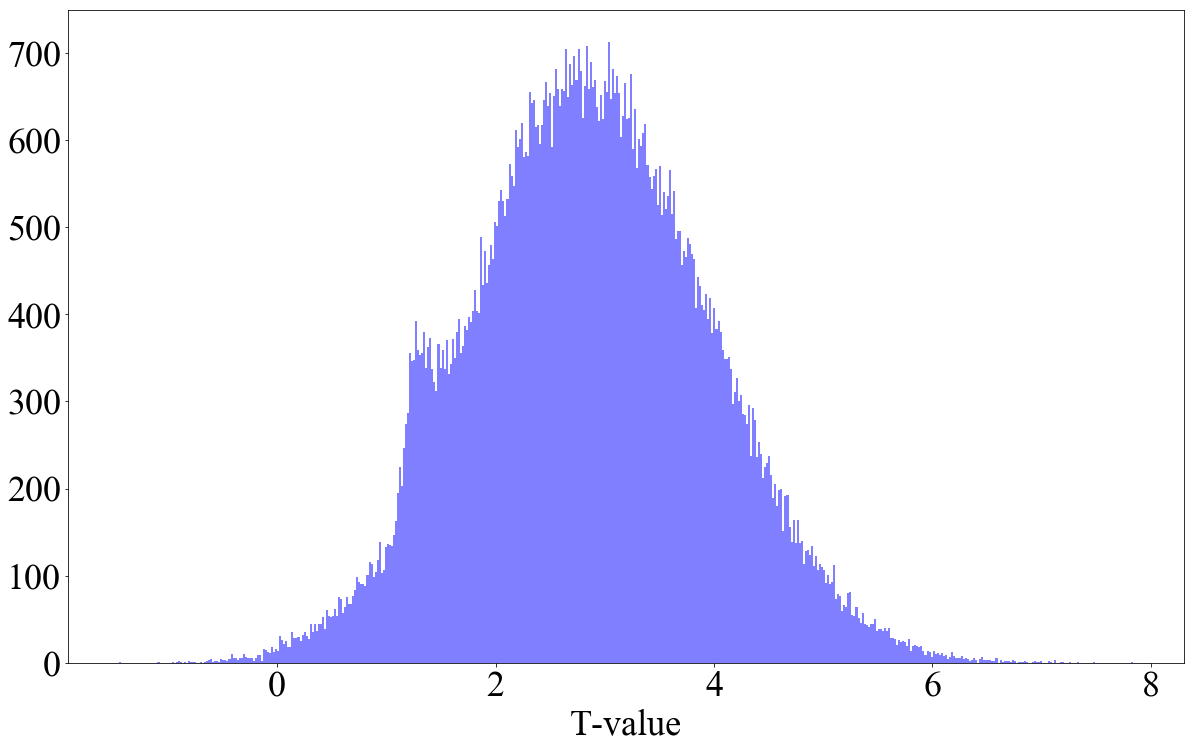

In [221]:
x=T
interval=None
num_bins=500
fig, ax = plt.subplots(figsize=(20,12))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 36
plt.xlabel("T-value")
plt.ylabel("")
n, bins, patches = plt.hist(x,num_bins, range=interval,facecolor='blue', alpha=0.5)
plt.savefig("images/countryComp")
plt.show()

In [218]:
np.mean(T),np.mean(P)

(2.856185553467883, 0.049769543476113516)